# Product Cross Selling Recommender System

**Business Problem Statement:**

Our financial services company has a diverse portfolio of investment products, yet the vast majority (99%) of our existing customers hold only one product—the Money Market Fund. Despite a broad array of offerings (Balanced Fund, Dollar Fund, Equity Fund, Fixed Income Fund, and Wealth Fund), our product penetration per customer (PPC) remains exceptionally low. This indicates a significant opportunity to cross-sell additional products to our existing customer base, which would increase customer value, loyalty, and the company’s overall profitability.

Currently, our customers’ data includes key information that could be leveraged to tailor product recommendations. These data points include:
- **Location (town)**
- **Gender**
- **Customer-relationship or beneficiary information** (as customers may have more than one relationship or beneficiary associated with them)
- **Customer age and DOB**
- **Beneficiary age and DOB**

Our goal is to create a user-friendly, intelligent recommender system that can analyze this existing data to suggest additional, relevant financial products to each customer. This system should be able to identify patterns or trends in customer profiles, uncover customer needs, and map those needs to suitable financial products, increasing our PPC in an efficient, cost-effective manner. 

**Objectives:**
1. **Customer Retention and Loyalty**: By offering personalized recommendations, we aim to build deeper, more personalized relationships with our customers, making them more likely to stay with us long-term.
2. **Increased Revenue per Customer**: A successful cross-selling strategy would increase the average number of products per customer, boosting overall portfolio revenue.
3. **User-Friendly Experience**: Ensuring a straightforward, accessible interface for customers to explore new financial products, particularly given that our target customers may have limited experience with financial diversification.

**Project Success Criteria:**
1. Develop a model that accurately predicts the next likely product(s) for each customer based on their profile and behavior.
2. Achieve a measurable increase in the PPC rate by the end of the initial deployment phase.
3. Design an intuitive interface that enhances the customer journey, with minimal friction, to encourage engagement and adoption.

### Data Understanding:

Our dataset comprises customer demographic and account information, which will serve as the foundation for building a cross-selling recommender system. By analyzing these features, we aim to uncover insights into customer behavior and needs, using patterns within the data to suggest relevant financial products. Key columns include identifiers, demographic data, and account-related features. Each attribute plays a role in shaping customer profiles, which will help guide product recommendations. Below is an overview of each column:

1. **Member Number (`member_no`)**  
   - A unique identifier for each customer.

2. **Registration Date (`reg_date`)**  
   - The date when the customer first registered with our company.

3. **Date of Birth (`dob`)**  
   - The customer’s date of birth, used to calculate age.

4. **House Number (`hse_no`)**  
   - The residential house number of the customer.

5. **Gender (`gender`)**  
   - The gender of the customer.

6. **Town (`town`)**  
   - The town or city of the customer’s residence.

7. **Relationship (`relationship`)**  
   - Indicates the relationship type with any listed beneficiaries.

8. **Beneficiary Date of Birth (`beneficiery_dob`)**  
   - The date of birth of a beneficiary associated with the customer.

9. **Portfolio (`portfolio`)**  
   - The financial products currently held by the customer.

---

### Data Considerations:

**Data Completeness and Consistency**  
   - Given the variety of data sources, ensure that each column is complete and uniformly formatted. Date fields like `dob`, `reg_date`, and `beneficiary_dob` must be consistent across the dataset, as inconsistencies could lead to inaccurate age and tenure calculations.

**Multiple Beneficiaries**  
   - Customers may have more than one beneficiary, creating potential complications in the data structure. Aggregate features, such as average or maximum beneficiary age, may be necessary to summarize information for modeling purposes.

**Categorical Label Standardization**  
   - Categorical features such as `gender`, `relationship`, and `town` should be standardized (e.g., no mixed casing or abbreviations) to ensure consistency. This will facilitate proper encoding for model input and avoid noise from variations in label text.

**Imbalanced Product Holding**  
   - With 99% of customers holding only the Money Market Fund, the portfolio data will be highly imbalanced. Careful sampling techniques and tailored evaluation metrics may be needed to prevent the model from being biased toward customers holding only this product.

**Data Privacy and Sensitivity**  
   - Sensitive data such as customer identification numbers, DOB, and financial product details require rigorous handling. Compliance with data privacy regulations is essential, and personal identifiers should be excluded from model features to maintain confidentiality.

**Geographic Granularity**  
   - Town data may vary in predictive value. Consider regional clustering or aggregation (e.g., grouping nearby towns or major regions) if individual town data proves to have limited relevance for model accuracy.

**Tenure Calculation and Influence**  
   - Calculating customer tenure from `reg_date` could help identify engagement level and readiness for cross-selling. Longer-tenure customers may be more open to new products, and segmentation based on tenure might reveal patterns in product uptake.

**Beneficiary Relationships and Cross-Selling Opportunities**  
   - Beneficiary data and relationship types could offer insights into cross-selling opportunities (e.g., suggesting long-term investment products for customers with young dependents). Analyzing these relationships is essential for creating a personalized recommendation approach.

**Age Grouping and Demographic Segmentation**  
   - Customer age, derived from `dob`, and beneficiary age could be grouped into segments to assess if specific age groups show higher receptivity to particular products. For example, older customers may favor fixed-income options, while younger ones might prefer equities.

In [72]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from surprise import accuracy
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_score, recall_score
from surprise import KNNBasic, Dataset, Reader
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, precision_score, accuracy_score
import tensorflow.keras.backend as K


In [4]:
import pandas as pd

df = pd.read_csv(r"C:\Users\ADMIN\Desktop\Capstone\single_member.csv")
df

,member_no,reg_date,dob,hse_no,gender,town,relationship,beneficiery_dob,portfolio
0,99996,2023-10-01 00:00:00.000,1998-04-06 00:00:00,Single Member,Female,NAIROBI,Partner,1998-01-26,Money Market
1,99996,2023-10-01 00:00:00.000,1998-04-06 00:00:00,Single Member,Female,NAIROBI,Partner,1998-01-26,Money Market
2,99996,2023-10-01 00:00:00.000,1998-04-06 00:00:00,Single Member,Female,NAIROBI,Partner,1998-01-26,Money Market
3,99996,2023-10-01 00:00:00.000,1998-04-06 00:00:00,Single Member,Female,NAIROBI,Partner,1998-01-26,Money Market
4,99996,2023-10-01 00:00:00.000,1998-04-06 00:00:00,Single Member,Female,NAIROBI,Partner,1998-01-26,Money Market
...,...,...,...,...,...,...,...,...,...
7532949,2,2011-06-07,1965-05-06,Single Member,Male,NAIROBI,NaN,NaN,Money Market
7532950,2,2011-06-07,1965-05-06,Single Member,Male,NAIROBI,NaN,NaN,Money Market
7532951,2,2011-06-07,1965-05-06,Single Member,Male,NAIROBI,NaN,NaN,Money Market
7532952,2,2011-06-07,1965-05-06,Single Member,Male,NAIROBI,NaN,NaN,Balanced Fund


In [5]:
df.columns

Index(['member_no', 'reg_date', 'dob', 'hse_no', 'gender', 'town',
       'relationship', 'beneficiery_dob', 'portfolio'],
      dtype='object')

In [6]:
df['member_no'].unique()

array([99996, 99994, 99993, ...,    19,     3,     2], dtype=int64)

In [7]:
df['gender'].unique()

array(['Female', 'Male', 'FEMALE', nan, 'MALE', 'F', 'M'], dtype=object)

In [8]:
df['relationship'].unique()

array(['Partner', 'Sister', 'Husband ', 'Husband', 'Daughter', 'Brother ',
       'Son', 'Daughter ', 'Wife', 'Father', 'Mother', 'Brother', 'son',
       'mother', 'father', 'Mother ', 'SPOUSE', 'FRIEND', 'Spouse ',
       'WIfe', 'Father ', 'Spouse', 'child', nan, 'Parent', 'wife',
       'Wife ', 'Son ', 'spouse', 'doughter', 'CHILD', 'ParentChild',
       'partner', 'brother', 'sister', 'MotheR', 'Friend', 'Child',
       'Cousin', 'Dad', 'Mum', 'MOTHER', 'WIFE', 'Sister ', 'SON',
       'BROTHER', 'FATHER', 'aunt ', 'Grandmother', 'HUSBAND', 'self',
       'husband', 'husband ', 'Owner', ' Grand daughter', 'Nephew',
       'SP0USE', 'Self', 'parent', 'SISTER', 'NIECE', 'Niece', 'daughter',
       'Sibling', 'DAUGHTER', 'AUNT', 'brother ', '254701361835',
       'Parent ', 'daughter ', 'FAITHER', 'Family ', 'SPOUSE ',
       'Sibling ', 'PARENT', 'CONFIDANT', 'MUM', 'DAD', 'wife ', 'family',
       'Trustee ', 'son ', 'mother ', 'MOTHER ', 'friend', 'spouse ',
       'S0N', 'SISTER

In [9]:
df['hse_no'].unique()

array(['Single Member'], dtype=object)

In [10]:
df['portfolio'].unique()

array(['Money Market', 'Dollar Fund', 'Wealth Fund', 'Equity Fund',
       'Fixed Income', 'Balanced Fund', 'MoneyMarket', nan], dtype=object)

In [11]:
df['town'].unique()

array(['NAIROBI', nan, 'NAIROBI ', 'THIKA', 'NAKURU', 'MOMBASA ',
       'NDANAI ', 'KISUMU', 'KIKUYU', 'JUJA', 'MACHAKOS', 'MERU',
       'KERICHO', 'MUKURWEINI', 'KATANGI', 'THIKA,KIAMBU', 'NANYUKI',
       'RUAI ', 'MALINDI', 'NYAHURURU', 'MUMIAS', 'KAKAMEGA', 'LODWAR',
       'Nairobi ', 'KITENGELA', 'LIMURU', 'THIKA ', 'MIGORI', 'ELDORET',
       'KITUI', 'RUARAKA', 'Ruiru', 'NJORO', 'EMBU', 'SORI', 'NGONG',
       'MASENO', 'GATUNDU', 'KAHURO', 'KILIFI', 'RUIRU', 'KERUGOYA',
       'KARATINA', 'KITALE ', 'MOMBASA', 'BUNGOMA', 'KISII', '-',
       'Nairobi', 'KINAMBA', 'SIAYA', 'KERICHO ', 'KIAMBU', 'KITALE',
       'BUSIA', 'RUNYENJES', 'VILLAGE MARKET', 'Kapsabet', 'KAGWE',
       'NANDI HILLS', 'KUTUS', 'DAGORETTI', 'LITEIN', 'KAJIADO', 'CHUKA',
       'NYERI', 'NAIROBI, NAIROBI', 'Kisumu ', 'KANJUKU', 'EMALI',
       'GILGIL', 'Kiambu ', 'KANGEMA', 'TIRIKI', 'KARATINA ', 'OTHAYA',
       'KARURI ,KIAMBU', 'MURANGA ', 'Mombasa', 'GATUKUYU ', 'MLOLONGO',
       'UTAWALA ', 'KAPE

In [12]:
df.isna().sum()

member_no                0
reg_date              1863
dob                  20038
hse_no                   0
gender                4667
town               1048216
relationship       1632933
beneficiery_dob    1086598
portfolio                9
dtype: int64

In [13]:
df.duplicated().sum()

7407066

The dataset overview provides a snapshot of the data quality, distribution, and any potential data issues that might impact analysis or the development of a cross-selling recommender system. Here’s a breakdown of each key insight:

### 1. **DataFrame Information**
   - **Shape**: The dataset contains **7,532,954 rows and 9 columns**, which is a substantial dataset in terms of both rows and memory usage (~517.2 MB).
   - **Data Types**: Only `member_no` is of integer type, while all other columns are objects (strings). Notably, date columns (`reg_date`, `dob`, `beneficiery_dob`) are stored as strings rather than date types, which may need conversion for time-based analysis.

### 2. **Basic Statistics**
   - **member_no**:
     - The average value (`mean`) is **36,693.57**, and the **max** is **118,011**, indicating the range of member IDs.
     - The minimum value is **2**, which could suggest an ID generation starting from low values.
     - These stats mainly help confirm the range and spread of `member_no`, which is likely to serve as a unique identifier for individuals.

### 3. **Null Values per Column**
   - Several columns have notable missing values:
     - **reg_date** has **1,863 missing values**. This could be important for time-based or recency-based analyses.
     - **dob** has **20,038 missing values**. Missing date of birth information could limit age-related recommendations.
     - **town** has a substantial **1,048,216 missing values** (over 13% of the dataset). Missing location data may impact region-specific recommendations.
     - **relationship** has **1,632,933 missing values**. The `relationship` status might provide insights into family structures, which could be useful for cross-selling, so the extent of missing values may affect analysis.
     - **beneficiery_dob** has **1,086,598 missing values**, which is considerable and could impact any beneficiary-related recommendations.
     - **portfolio** has **9 missing values**. This is a small amount but may need to be addressed if portfolio type is crucial for targeting.

### 4. **Unique Values per Column**
   - **member_no**: There are **75,513 unique IDs**, indicating that some `member_no` entries have multiple rows. This may imply multiple products or relationships associated with each member.
   - **reg_date** has **3,163 unique values**, suggesting members registered over a wide range of dates.
   - **dob** has **19,092 unique values**, indicating some duplicate birth dates, which is common.
   - **hse_no** has only **1 unique value**, meaning all entries have the same value ("Single Member"), which may be a default placeholder.
   - **gender** shows **6 unique values**, indicating some inconsistencies or multiple formats (e.g., "Female" and "FEMALE").
   - **town** and **relationship** have **973** and **494 unique values** respectively, suggesting a broad diversity in locations and relationships.
   - **beneficiery_dob** has **27,488 unique values**, showing diversity but likely also duplication.
   - **portfolio** has **7 unique values**, suggesting multiple product types.

### 5. **Gender Distribution**
   - The `gender` column shows some data quality issues with **6 unique values**:
     - The expected values ("Female" and "Male") are the majority, comprising about 66% and 34%, respectively.
     - Minor variations like "F", "M", "MALE", and "FEMALE" likely represent data entry inconsistencies. Cleaning these values to a standard format ("Female" and "Male") would improve analysis accuracy.

### 6. **Date Ranges**
   - **reg_date**:
     - Range is from **March 4, 2022, to October 6, 2023**. This shows registration dates over about 1.5 years, which is relevant for recency analysis.
   - **dob**:
     - Range is from **January 1, 1934, to July 31, 2015**. The minimum value suggests older members, while the maximum indicates younger members, likely around 8 years old in 2023. This is useful for age segmentation.
   - **beneficiery_dob**:
     - The range spans from **December 26, 1694, to October 3, 2202**. The minimum and maximum dates indicate significant anomalies likely due to data entry errors or placeholder values. Dates outside a reasonable range (e.g., before 1900 or after 2023) may need correction or filtering for analysis.

---

### Summary
- **Data Quality**: Several columns (`gender`, `town`, `relationship`, `beneficiery_dob`) have issues with missing values or inconsistent entries, which may require cleaning.
- **Date Columns**: Converting and cleaning date columns (e.g., `reg_date`, `dob`, `beneficiery_dob`) will be essential, especially for any analysis involving age, registration recency, or beneficiary relationships.
- **ID Uniqueness**: `member_no` has duplicate entries, likely indicating multiple entries per member. Understanding this structure is key to correctly interpreting member-level data.
- **Next Steps**:
  - Standardize values in the `gender` column.
  - Filter or clean outliers in `beneficiery_dob`.
  - Address missing values, especially in `relationship`, `town`, and `dob`.

This dataset overview gives a clear starting point for preparing the data, identifying areas for cleaning, and understanding the distribution of key attributes, all of which will enhance the quality of the cross-selling recommender system.

In the below code block, we drop duplicated values.

## Step 2: Data CLeaning:

### Data Cleaning Process Outline for Numerical and Categorical Data

Given that our dataset is composed of **Numerical** and **Categorical** columns, we'll tailor our cleaning process to handle each type effectively, ensuring the data is prepared for robust analysis and modeling.

---

### Data Cleaning Process Summary

1. **Handle Missing Values**: Impute or drop missing data based on the importance of each column.


In [14]:
df = df.drop_duplicates()

From our problem statement, we aim to cross sell investment products depending on Age, Gender and Location. Therefore, we are going to drop some columns which are irrelevant. e.g. hse_no, beneficiary_dob,reg_date.

In [15]:
df=df.drop(columns=['reg_date','hse_no'])

In [16]:
df.isna().sum()

member_no              0
dob                  238
gender                82
town               15026
relationship       14308
beneficiery_dob    13937
portfolio              4
dtype: int64

In [17]:
df.relationship.unique()

array(['Partner', 'Sister', 'Husband ', 'Husband', 'Daughter', 'Brother ',
       'Son', 'Daughter ', 'Wife', 'Father', 'Mother', 'Brother', 'son',
       'mother', 'father', 'Mother ', 'SPOUSE', 'FRIEND', 'Spouse ',
       'WIfe', 'Father ', 'Spouse', 'child', nan, 'Parent', 'wife',
       'Wife ', 'Son ', 'spouse', 'doughter', 'CHILD', 'ParentChild',
       'partner', 'brother', 'sister', 'MotheR', 'Friend', 'Child',
       'Cousin', 'Dad', 'Mum', 'MOTHER', 'WIFE', 'Sister ', 'SON',
       'BROTHER', 'FATHER', 'aunt ', 'Grandmother', 'HUSBAND', 'self',
       'husband', 'husband ', 'Owner', ' Grand daughter', 'Nephew',
       'SP0USE', 'Self', 'parent', 'SISTER', 'NIECE', 'Niece', 'daughter',
       'Sibling', 'DAUGHTER', 'AUNT', 'brother ', '254701361835',
       'Parent ', 'daughter ', 'FAITHER', 'Family ', 'SPOUSE ',
       'Sibling ', 'PARENT', 'CONFIDANT', 'MUM', 'DAD', 'wife ', 'family',
       'Trustee ', 'son ', 'mother ', 'MOTHER ', 'friend', 'spouse ',
       'S0N', 'SISTER

In [18]:
df['relationship'] = df['relationship'].str.lower().str.strip()
df['relationship'].value_counts().to_string().replace("\n", " ")

"mother                  18900 son                     18207 daughter                18010 sister                  12234 wife                    11190 husband                  9563 brother                  7768 father                   6738 spouse                   3311 child                    1567 parent                    627 friend                    393 niece                     369 nephew                    313 cousin                    309 aunt                      220 partner                   203 sibling                   199 fiance                    137 guardian                  117 fiancee                   100 uncle                      85 grandson                   74 grandmother                61 family                     51 self                       42 -                          40 estate                     39 grand daughter             31 dad                        29 granddaughter              29 mum                        27 girlfriend                 26 doughter 

In [19]:
df['relationship'] = df['relationship'].fillna('son')
df['relationship'].isna().sum()


0

In [20]:
# Convert all entries to lower case and strip whitespace for uniformity
df['relationship'] = df['relationship'].str.lower().str.strip()

# Mapping dictionary
relationship_map = {
    'partner': [
        'partner', 'spouse', 'sp0use','husband', 'wife', 'fiancee', 'ex-wife', 'spouce', 'fiancé',
        'husband ', 'sponse', 'spouse ', 'wiFe', 'wifE', 'wife ', 'spouse', 'married', 'marriage',
        'husband/spouse', 'ex-wife', 'fiance ', 'fiance', 'married ', 'myson', 'baby mama ',
        'fiancee ', 'souse', 'hubby', 'dating', 'boyfriend', 'girlfriend', 'ex wife', 'boyfriend ',
        'girlfriend ', 'wife/guardian', 'ex husband', 'girl friend', 'fiancée', 'sopouse', 'spoudse',
        'soPOUSE', 'spause', 'sposue', 'ex husband', 'love', 'b/f', 'g/f', 'divorcee', 'ex spouse',
        'bf', 'gf', 'b/f', 'g/f', 'fiancé ', 'domesticpartner', 'domestic partner', 'dating', 'exwife',
        'exhusband', 'wive', 'husb', 'exspouse', 'partner ', 'significant other', 'fiancee','companion','Partner',
        'Husband ', 'Husband',  'Wife',   'SPOUSE' , 'Spouse ', 'WIfe', 'Spouse',  'wife', 'Wife ', 'spouse', 'partner',
        'HUSBAND', 'husband', 'husband ',  'SP0USE' , 'SPOUSE ',  'wife ',
        'spouse ', 'Partner ' , 'FIANCEE', 'Fiancee',  'HUSBAND ',  'FIANCE', 
        'wIFE', 'PARTNER',  'Domestic Partner', 'PATNER', 'Fiance ', 'PARTNER ',  'hUSBAND',  'Boyfriend ',
        'WIFE ', 'fiancee', 'JOINT PARTNER', 'Fiancé ' , 'Husband/spouse', 'SPOUCE',  'Patner', 'Spouce',  
        'Fiance', 'BOYFRIEND', 'EX-WIFE',  'PARNT',  'GIRLFRIED'
    ],
    'child': [
        'child', 'kid', 'daughter', 'son', 'children', 'daughter33', 'doughter', 'daugther', 'doughter ',
        'daugther', 'son ', 'daughter ', 'child minor', 'kids', 'baby', 'infant', 'toddler', 'sonS',
        'minor', 'child ', 'son/sister', 'chid', 'newborn', 'son/brother', 'childnephew',
        'chils', 'chiLD', 'kID', 'dau`', 'daugher', 'childnephew', 'my son','child', 'son', 'dau', 
        'daughter', 'daughter33', 'my son', 'infant', 'childnephew', 'kids', 'baby', 'ChiLD', 'CHID',
        'sON', 'cHILS', 'CHID', 'CHIILD', 'KID', 'FOSTER' 'DAUGHTER', 'CHILD MINOR', 'MINOR', 'CHILDREN', 
        'SOM', 'CHILDREN', 'JUNIOR', 'BABY',  'CHIL', 'DAUGHTER/CHILDDAUGHER', 'CHILF', 'DOUGHTER', 'DAIGHTER', 
        'DAUGHTE', 'DAUGHETR', 'S0N','MYSON','child','CHILD','Child ','DAUGHTER/CHILD','child ','CHILD MINOR',
        'CHILD ','children','CHILDREN','ChILD','ChiLD'
    ],
    'parent': [
        'mother', 'mom', 'mum', 'father', 'dad', 'parent', 'parents', 'mother ', 'father ', 'mOTHER',
        'dad ', 'mum ', 'mom ', 'mummy', 'daddy', 'papa', 'mama', 'mother in law', 'father in law',
        'mothers', 'fathers', 'moms', 'mums', 'father-in-law', 'mother-in-law', 'mommy', 'dadi', 'momi',
        'parent ', 'mother to son', 'mother of child', 'parents', 'mother- guardian', 'father - guardian',
        'parentchild', 'parental', 'parenthood', 'parenting', 'mother IN LAW', 'mom in law', 'dad in law',
        'mum in law', 'parenting', 'fatherhood', 'motherhood', 'parent ', 'grandparent', 'step mother',
        'step father', 'step-mother', 'step-father','Parent', 'Parents', 'Mother', 'Mothers', 'Mom', 'Mum', 
        'Father', 'DAD', 'Dad', 'Guardian', 'Grandmother', 'Grandfather', 'Step-mother', 'Step-father', 'Foster parent',
        'Mother-in-law', 'Father-in-law', 'ParentChild', 'Mama', 'Mummy', 'Dadi', 'Mother TO SON', 'PARENT', 'MOther'
    ],
    'self': [
        'self', 'owner', 'me', 'myself', 'self ', 'owner ', 'i', 'myself ', 'personal', 'individual',
        'own', 'my own', 'self-employed', 'proprietor', 'me ', 'self employed', 'self own', 'personal account',
        'my account', 'own account'
    ],
    'guardian': [
        'guardian', 'custodian', 'trustee', 'guard', 'guardian ', 'custodian ', 'trustee ', 'guard ',
        'legal guardian', 'guardianship', 'custodianship', 'trusteeship', 'protector', 'caregiver',
        'conservator','conservator', 'foster parent', 'foster guardian', 'legal custodian', 'guardian-mother', 'guardian father'
    ],
    'sibling': [
        'siblings', 'brother', 'sister', 'sibling', 'brother ', 'sister ', 'bro', 'sis', 'brothers', 'sisters',
        'sibling ', 'brother-in-law', 'sister-in-law', 'sibling in law', 'brother and sister', 'sibbling',
        'siBLING', 'sibblings', 'sister in law', 'brother in law', 'sister/guardian', 'sister - guardian',
        'sister-guardian', 'bros', 'sisses', 'step-sister', 'step-brother', 'half-sister', 'half-brother', 'broski','Sister', 'Brother ','brother', 'sister',
       'Sister ', 'SISTER','Sibling', 'brother ','Sibling ','SISTER ','Sistet', 'Bro', 'Sis', 'SiBLING',
        'SIBLING',  's0n', 'sister ''sISTER', 'sisiter', ' BROTHER','BRother', 'SisteR', 'SIS', 
       'som',
       'Sister- Custodian', 
       'SIIBLING', 'SIBLINGS','Brother and sister',
       'Sibbling'
    ],
    'relative': [
        'cousin', 'nephew', 'grand child', 'niece', 'grandmother', 'granddaughter', 'grandson', 'grandfather', 'uncles', 'aunties',
        'aunt', 'uncle', 'granny', 'grandparent', 'grand child', 'relative', 'relatives', 'cousins', 'uncles',
        'aunties', 'aunts', 'grandparents', 'great grandmother', 'great grandfather', 'grand children', 'extended family',
        'grandmother ', 'grandfather ', 'nephew ', 'niece ', 'cousin ', 'aunt ', 'uncle ', 'granny ', 'granddaughter ',
        'grandson ', 'grandchild', 'grandchild ', 'grandchildren', 'grandkids', 'great grandparent', 'ancestors', 'descendants',
        'kin', 'kinship', 'next of kin', 'in-laws', 'inlaw', 'in laws', 'extended relatives', 'b inlaw', 'in law','family tree', 'Cousin', ' Grand daughter', 'Nephew', 'NIECE', 'Niece', 'AUNT', 'relative', 'AUNTIE', 'B INLAW', 'COUSIN', 'aunt', 'UNCLE', 'GRAND SON', 'Nephew ', 'Cousin ', 'nephew', 'GRAND DAUGHTER', 'Niece ', 'granddaughter', 'grandson', 'RELATIVE', 'Daughter-in-law ', 'GRANDMOTHER', 'Relative ', 'uncle',
'NEPHEW', 'Grand daughter', 'DAUGHTER-IN-LAW', 'COUSN', 'Uncle', 'Granddaughter ', 'Aunt ', 'cousin', 'GRANDSON ', 'uncle ', 'AUNTY', 'FATHER-IN-LAW', 'GRAND FATHER', 'DGRAND DAUGHTER', 'GRAND MOTHER', 'UN,CLE', 'GRAND CHILD', 'Sister in law', 'Grand Daughter', 'GRANDDAUGTER', 'NiecE', 'Brother-IN-LAW', 'Grand mother', 'GRANDFATHER', 'Daughter in law', 'Sister-IN-LAW', 'GRAND-DAUGHTER', 'GRANNY', 
'GRANDCHILD', 'Aunty', 'Cousins', 'Cousins ', 'Auntie', 'GRANDPA', 'Brother in Law', 'IN LAW', 'Granddaughter', 'niece', 'Grand Son', 'Sister-in law', 'CLOUSIN', 'GRANSON', 'Sister IN LAW', 'Brother-in-law', 'Sister-Inlaw', 'Brother in law', 'GRAND-MOTHER', 'Grand-mother', 'Mother-in-law', 'SISTER IN LAW ', 'Grand mother ', 'Childnephew', 'Grand daughter ', 'auntie', 'In law', 'Sister in-law', 'Aunty '
    ],
    'friends': ['friend','closefriend', 'confidant', 'friend ',
        'peers', 'acquaintance', 'comrade', 'pal', 'buddy', 'mate', 'fellow', 'ally', 'supporter',
        'confidante', 'friend of the family', 'family friend',
        'peer', 'companion', 'companions'
    ],
    'professional':['colleague', 'coworker', 'partner in law',
        'associate', 'advisor', 'mentor', 'colleague ', 'coworker ',
        'associate ', 'colleague', 'professional', 'mentor', 'adviser', 'counselor', 'legal representative', 'executor', 'business partner',
        'co-worker', 'workmate', 'teammate',
        'partner in business', 'business associate', 'collaborator', 'collegue','estate'
    ],
    'other': ['spiritual advisor','sponsor'
    ]
}

# Function to apply the mapping
def map_relationship(value):
    for category, keywords in relationship_map.items():
        if any(keyword == value for keyword in keywords):
            return category
    return 'other'  # Default category if no matches found

# Apply the mapping function to the 'relationship' column
df['relationship'] = df['relationship'].apply(map_relationship)

# Show the value counts of each category
print(df['relationship'].value_counts())

child           52152
parent          26352
partner         24578
sibling         20240
relative         1534
friends           396
other             392
guardian          128
professional       67
self               49
Name: relationship, dtype: int64


In [21]:
df.columns

Index(['member_no', 'dob', 'gender', 'town', 'relationship', 'beneficiery_dob',
       'portfolio'],
      dtype='object')

In [22]:
df.gender.value_counts()

Female    83178
Male      42480
F            92
M            48
FEMALE        4
MALE          4
Name: gender, dtype: int64

In [23]:
df.gender.isna().sum()

82

In [24]:
df['gender']=df.gender.fillna('Female')
df['gender'].isna().sum()

0

In [25]:
gender_map = {
    'Female':'Female','F':'Female','FEMALE':'Female',
    'Male':'Male','M':'Male','MALE':'Male',
}

df['gender_mapped'] = df['gender'].replace(gender_map)


In [26]:
df.head()

,member_no,dob,gender,town,relationship,beneficiery_dob,portfolio,gender_mapped
0,99996,1998-04-06 00:00:00,Female,NAIROBI,partner,1998-01-26,Money Market,Female
14,99996,1998-04-06 00:00:00,Female,NAIROBI,sibling,2001-03-04,Money Market,Female
28,99994,1966-01-01 00:00:00,Female,NaN,partner,1962-01-01,Money Market,Female
40,99993,1974-01-01 00:00:00,Female,NAIROBI,partner,1970-09-29,Money Market,Female
70,99993,1974-01-01 00:00:00,Female,NAIROBI,child,1994-01-01,Money Market,Female


In [27]:
df.dob.value_counts()

1962-01-01             541
1960-01-01             360
1968-01-01             320
1970-01-01             311
1974-01-01             311
                      ... 
1957-04-18               1
1996-02-03 00:00:00      1
1958-05-10 00:00:00      1
1951-08-15               1
1973-08-13 00:00:00      1
Name: dob, Length: 19092, dtype: int64

In [28]:
df['dob'] = df.dob.fillna('1962-01-01')
df.dob.isna().sum()

0

In [29]:
from datetime import datetime

In [30]:
df['dob'] = pd.to_datetime(df['dob'])
today = datetime.today()
df['member_age'] = today.year - df['dob'].dt.year 
df.head()


,member_no,dob,gender,town,relationship,beneficiery_dob,portfolio,gender_mapped,member_age
0,99996,1998-04-06,Female,NAIROBI,partner,1998-01-26,Money Market,Female,26
14,99996,1998-04-06,Female,NAIROBI,sibling,2001-03-04,Money Market,Female,26
28,99994,1966-01-01,Female,NaN,partner,1962-01-01,Money Market,Female,58
40,99993,1974-01-01,Female,NAIROBI,partner,1970-09-29,Money Market,Female,50
70,99993,1974-01-01,Female,NAIROBI,child,1994-01-01,Money Market,Female,50


In [31]:
df['beneficiery_dob']=pd.to_datetime(df['beneficiery_dob'])
current_date = datetime.now()
df['beneficiery_age'] = current_date.year - df['beneficiery_dob'].dt.year 

In [32]:
df.beneficiery_age.describe()

count    111951.000000
mean         38.098409
std          22.160964
min        -178.000000
25%          24.000000
50%          36.000000
75%          53.000000
max         330.000000
Name: beneficiery_age, dtype: float64

In [33]:
df.portfolio.value_counts()

Money Market     119710
Equity Fund        2014
Dollar Fund        1480
Balanced Fund      1180
Fixed Income       1101
Wealth Fund         398
MoneyMarket           1
Name: portfolio, dtype: int64

In [34]:
df['portfolio']=df.portfolio.fillna('Money Market')
df.portfolio.isna().sum()

0

In [35]:
portfolio_map ={
    'Money Mrket':'Money Market','MoneyMarket':'Money Market',
    'Equity Fund':'Equity Fund',
    'Dollar Fund':'Dollar Fund',
    'Balanced Fund':'Balanced Fund',
    'Fixed Income':'Fixed Income',
    'Wealth Fund':'Wealth Fund',
}
df['portfolio_map'] = df['portfolio'].replace(portfolio_map)

In [36]:
df.head()

,member_no,dob,gender,town,relationship,beneficiery_dob,portfolio,gender_mapped,member_age,beneficiery_age,portfolio_map
0,99996,1998-04-06,Female,NAIROBI,partner,1998-01-26,Money Market,Female,26,26.0,Money Market
14,99996,1998-04-06,Female,NAIROBI,sibling,2001-03-04,Money Market,Female,26,23.0,Money Market
28,99994,1966-01-01,Female,NaN,partner,1962-01-01,Money Market,Female,58,62.0,Money Market
40,99993,1974-01-01,Female,NAIROBI,partner,1970-09-29,Money Market,Female,50,54.0,Money Market
70,99993,1974-01-01,Female,NAIROBI,child,1994-01-01,Money Market,Female,50,30.0,Money Market


In [37]:
df.town.isna().sum()

15026

In [38]:
df.town.value_counts()

NAIROBI             56997
Nairobi             10261
THIKA                3000
NAKURU               2608
MOMBASA              2440
                    ...  
NAIROBI WEST            1
NANDI HILLS             1
KIMININI                1
ENTERPRISE  ROAD        1
Syokimau                1
Name: town, Length: 973, dtype: int64

In [39]:
df['town'] = df.town.fillna('Unknown')
df.town.isna().sum()

0

In [40]:
df.head()

,member_no,dob,gender,town,relationship,beneficiery_dob,portfolio,gender_mapped,member_age,beneficiery_age,portfolio_map
0,99996,1998-04-06,Female,NAIROBI,partner,1998-01-26,Money Market,Female,26,26.0,Money Market
14,99996,1998-04-06,Female,NAIROBI,sibling,2001-03-04,Money Market,Female,26,23.0,Money Market
28,99994,1966-01-01,Female,Unknown,partner,1962-01-01,Money Market,Female,58,62.0,Money Market
40,99993,1974-01-01,Female,NAIROBI,partner,1970-09-29,Money Market,Female,50,54.0,Money Market
70,99993,1974-01-01,Female,NAIROBI,child,1994-01-01,Money Market,Female,50,30.0,Money Market


In [41]:
new_df=df.drop(columns=['dob','gender','portfolio','beneficiery_dob'])
new_df.head()

,member_no,town,relationship,gender_mapped,member_age,beneficiery_age,portfolio_map
0,99996,NAIROBI,partner,Female,26,26.0,Money Market
14,99996,NAIROBI,sibling,Female,26,23.0,Money Market
28,99994,Unknown,partner,Female,58,62.0,Money Market
40,99993,NAIROBI,partner,Female,50,54.0,Money Market
70,99993,NAIROBI,child,Female,50,30.0,Money Market


In [42]:
new_df['beneficiery_age']=new_df['beneficiery_age'].fillna(35.0)
new_df.beneficiery_age.isna().sum()

0

In [43]:
# Set reasonable age bounds
lower_bound = 0
upper_bound = 100

# Create a copy of original ages for comparison if needed
original_ages = new_df['beneficiery_age'].copy()

# Replace outliers by clipping to bounds
new_df['beneficiery_age'] = new_df['beneficiery_age'].clip(lower=lower_bound, upper=upper_bound)

In [44]:
lower_bound = 0
upper_bound = 100

# Create a copy of original ages for comparison if needed
original_ages = new_df['member_age'].copy()

# Replace outliers by clipping to bounds
new_df['member_age'] = new_df['member_age'].clip(lower=lower_bound, upper=upper_bound)

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

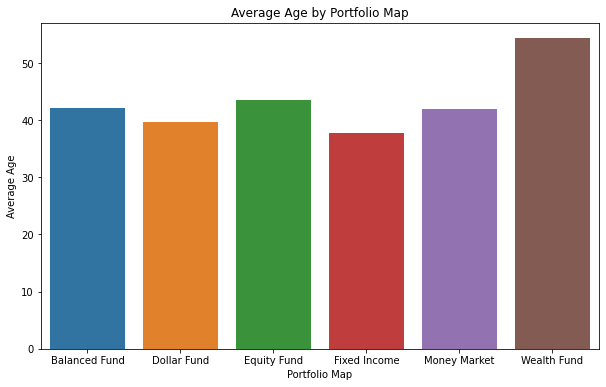

In [46]:
average_age = new_df.groupby('portfolio_map')['member_age'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='portfolio_map', y='member_age', data=average_age)
plt.title('Average Age by Portfolio Map')
plt.xlabel('Portfolio Map')
plt.ylabel('Average Age')
plt.show()


In [47]:
new_df.columns

Index(['member_no', 'town', 'relationship', 'gender_mapped', 'member_age',
       'beneficiery_age', 'portfolio_map'],
      dtype='object')

In [48]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125888 entries, 0 to 7532842
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   member_no        125888 non-null  int64  
 1   town             125888 non-null  object 
 2   relationship     125888 non-null  object 
 3   gender_mapped    125888 non-null  object 
 4   member_age       125888 non-null  int64  
 5   beneficiery_age  125888 non-null  float64
 6   portfolio_map    125888 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 7.7+ MB


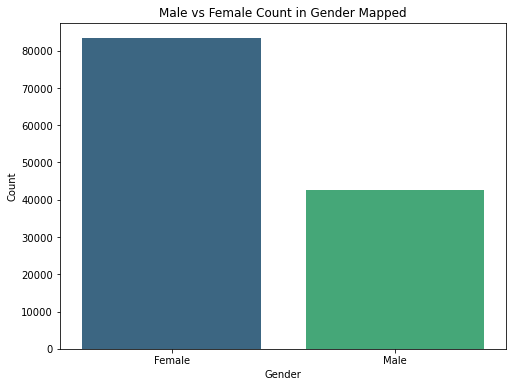

In [49]:
plt.figure(figsize=(8, 6))
sns.countplot(data=new_df, x='gender_mapped', palette='viridis')
plt.title('Male vs Female Count in Gender Mapped')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

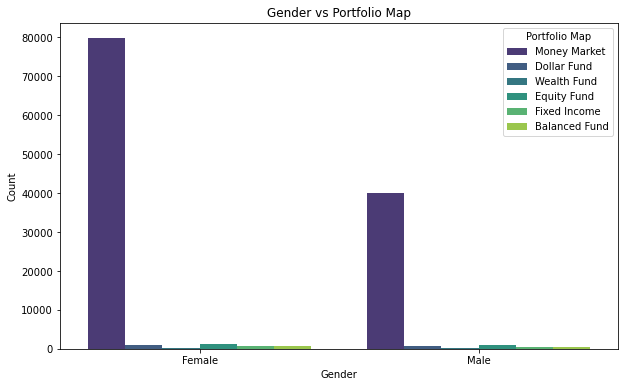

In [50]:
plt.figure(figsize=(10, 6))
sns.countplot(data=new_df, x='gender_mapped', hue='portfolio_map', palette='viridis')
plt.title('Gender vs Portfolio Map')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Portfolio Map')
plt.show()

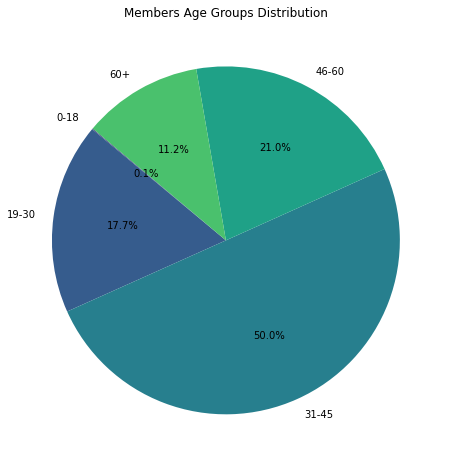

In [51]:
age_bins = [0, 18, 30, 45, 60, 100]
age_labels = ['0-18', '19-30', '31-45', '46-60', '60+']
new_df['age_group'] = pd.cut(new_df['member_age'], bins=age_bins, labels=age_labels)
age_counts = new_df['age_group'].value_counts().sort_index()
plt.figure(figsize=(8, 8))
plt.pie(age_counts, labels=age_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))
plt.title('Members Age Groups Distribution')
plt.show()

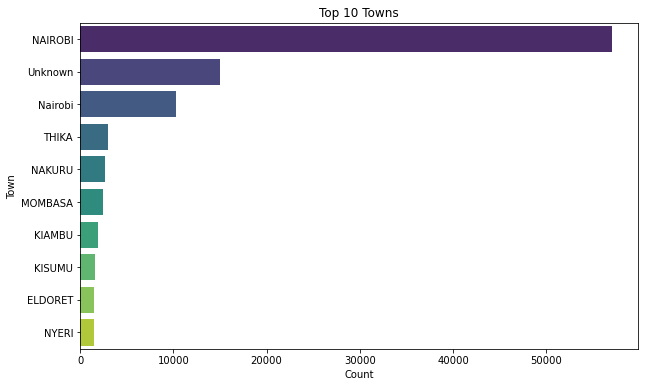

In [52]:
top_10_towns = new_df['town'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_towns.values, y=top_10_towns.index, palette='viridis')
plt.title('Top 10 Towns')
plt.xlabel('Count')
plt.ylabel('Town')
plt.show()

In [53]:
new_df['town']=new_df['town'].str.lower()
new_df['town'].unique()

array(['nairobi', 'unknown', 'nairobi ', 'thika', 'nakuru', 'mombasa ',
       'ndanai ', 'kisumu', 'kikuyu', 'juja', 'machakos', 'meru',
       'kericho', 'mukurweini', 'katangi', 'thika,kiambu', 'nanyuki',
       'ruai ', 'malindi', 'nyahururu', 'mumias', 'kakamega', 'lodwar',
       'kitengela', 'limuru', 'thika ', 'migori', 'eldoret', 'kitui',
       'ruaraka', 'ruiru', 'njoro', 'embu', 'sori', 'ngong', 'maseno',
       'gatundu', 'kahuro', 'kilifi', 'kerugoya', 'karatina', 'kitale ',
       'mombasa', 'bungoma', 'kisii', '-', 'kinamba', 'siaya', 'kericho ',
       'kiambu', 'kitale', 'busia', 'runyenjes', 'village market',
       'kapsabet', 'kagwe', 'nandi hills', 'kutus', 'dagoretti', 'litein',
       'kajiado', 'chuka', 'nyeri', 'nairobi, nairobi', 'kisumu ',
       'kanjuku', 'emali', 'gilgil', 'kiambu ', 'kangema', 'tiriki',
       'karatina ', 'othaya', 'karuri ,kiambu', 'muranga ', 'gatukuyu ',
       'mlolongo', 'utawala ', 'kapenguria', 'suna', 'bomet', 'kenol ',
       '

## Rule Based Recommendation 

In [54]:
new_df['gender_mapped'] = new_df['gender_mapped'].replace({'Female': 0, 'Male': 1})

In [55]:
new_df.head()

,member_no,town,relationship,gender_mapped,member_age,beneficiery_age,portfolio_map,age_group
0,99996,nairobi,partner,0,26,26.0,Money Market,19-30
14,99996,nairobi,sibling,0,26,23.0,Money Market,19-30
28,99994,unknown,partner,0,58,62.0,Money Market,46-60
40,99993,nairobi,partner,0,50,54.0,Money Market,46-60
70,99993,nairobi,child,0,50,30.0,Money Market,46-60


In [75]:
new_df.age_group.unique()

['19-30', '46-60', '31-45', '60+', '0-18']
Categories (5, object): ['0-18' < '19-30' < '31-45' < '46-60' < '60+']

In [74]:
new_df.portfolio_map.unique()

array(['Money Market', 'Dollar Fund', 'Wealth Fund', 'Equity Fund',
       'Fixed Income', 'Balanced Fund'], dtype=object)

In [56]:
X = new_df[['member_no', 'town', 'member_age', 'gender_mapped']]
y = new_df['portfolio_map']

In [57]:
X.head()

,member_no,town,member_age,gender_mapped
0,99996,nairobi,26,0
14,99996,nairobi,26,0
28,99994,unknown,58,0
40,99993,nairobi,50,0
70,99993,nairobi,50,0


In [78]:
def recommend(row):
    age = row['member_age']
    gender = row['gender_mapped']
    age_group = row['age_group']
    portfolio = row['portfolio_map']

    # Rule-based recommendation
    if 0 <= age <= 18:
        account = "Junior Account"
        investment = f"Invest in popular portfolios for age group {age_group} and gender {gender}."
    elif 19 <= age <= 30:
        account = "Student Account"
        investment = f"Diversify beyond current portfolio. Consider other investments for age group {age_group} and gender {gender}."
    elif 31 <= age <= 45:
        account = "Young Adult Account"
        investment = f"Consider other investments for age group {age_group} and gender {gender}, besides current portfolio."
    elif 46 <= age <= 60:
        account = "Mature Account"
        investment = f"Invest in popular portfolios for age group {age_group} and gender {gender}."
    else:  # age > 60
        account = "Senior Account"
        investment = f"Invest in popular portfolios for age group {age_group} and gender {gender}."

    return pd.Series([account, investment])


In [ ]:
recommend(new_df.iloc[])

0                                       Mature Account
1    Invest in popular portfolios for age group 46-...
dtype: object

In [58]:
label_encoder = LabelEncoder()

# Encode 'town' and 'portfolio_map'
X = df[['member_no', 'town', 'member_age', 'gender_mapped']].copy()
X['gender'] = label_encoder.fit_transform(X['gender_mapped'])

# Apply One-Hot Encoding to 'town' (or other multi-category) column
X_encoded = pd.get_dummies(X, columns=['town'], drop_first=True)
y = label_encoder.fit_transform(y)

In [59]:
X_encoded = X_encoded.drop(columns=['gender_mapped'])

In [60]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (125888, 5)
y shape: (125888,)


In [62]:
x_train,x_test,y_train,y_test = train_test_split(X_encoded,y,test_size=0.2,random_state=42)

In [64]:
x_train.head()

,member_no,member_age,gender,town_ Nairobi,"town_ Nairobi County,",town_-,town_.,town_.,town_0,town_00,...,town_rongai,town_ruiru,town_siaya,town_stockholm,town_tawa,town_thika,town_thika,town_ugunja,town_wangige,town_wite-makueni
175991,90696,29,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1710008,56368,35,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
582950,77988,52,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7182344,2347,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5495936,14367,34,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


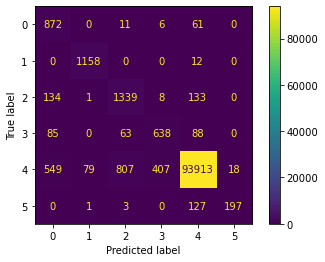

In [73]:
dt = DecisionTreeClassifier()
dt_model = dt.fit(x_train,y_train)
ConfusionMatrixDisplay.from_estimator(estimator=dt_model, X=x_train, y=y_train);

In [70]:
y_pred = dt_model.predict(x_test)
model_accuracy = accuracy_score(y_test,y_pred)
model_accuracy


0.9234649297005322